In [45]:
import yfinance as yf
import pandas as pd
import datetime
import tensorflow as tf
import keras
import seaborn
import numpy as np

In [46]:
start = pd.to_datetime('2010-08-02')
end = pd.to_datetime('2018-08-02')
stock = ['GOOG']
data = yf.download(stock, start = start, end = end)
dates = data.index
columns = data.columns
data.index.name = "Date" #add date as column
data.reset_index(inplace = True)
data.index.name = "timeT" #add time as column
data.reset_index(inplace = True)
print(data.head())

print(len(data))
data_train = data.iloc[0:1600,] ##train set
data_test = data.iloc[1601:2001,]
print(len(data_train))
print(len(data_test))

[*********************100%***********************]  1 of 1 completed
   timeT       Date       Open       High        Low      Close  Adj Close  \
0      0 2010-08-02  12.179100  12.285949  12.128041  12.214467  12.214467   
1      1 2010-08-03  12.216709  12.265526  12.123558  12.200021  12.200021   
2      2 2010-08-04  12.258552  12.627668  12.230407  12.610732  12.610732   
3      3 2010-08-05  12.600022  12.667519  12.541990  12.655066  12.655066   
4      4 2010-08-06  12.587818  12.596286  12.354941  12.458801  12.458801   

      Volume  
0   74626675  
1   72362219  
2  153071607  
3   97178890  
4  133277692  
2015
1600
400


<Axes: >

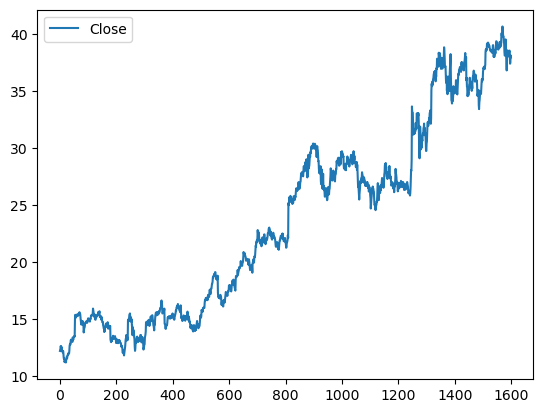

In [47]:
seaborn.lineplot(data_train.loc[:,["Close"]]) #plot the value of close

In [48]:
##first let us fit log(Y) = t + c, with Y value of the stock and t the time and c some constant
PF = np.polyfit(data_train.loc[:,"timeT"], np.log(data_train.loc[:,"Close"]), 1)
PF

array([7.64030428e-04, 2.48928574e+00])

In [49]:
#use the estimates to calculate the curve
removeExponent = data_train.loc[:,["Close", "timeT"]]
removeExponent["Estimate"] = np.exp(PF[0]*removeExponent["timeT"]+PF[1])
removeExponent["NoExp"] = removeExponent["Close"]/removeExponent["Estimate"] ##devide by trend

<Axes: ylabel='NoExp'>

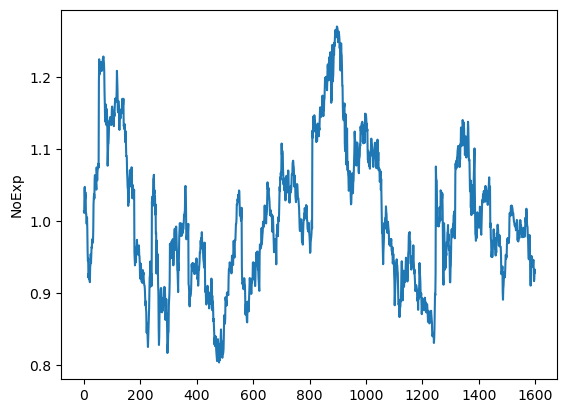

In [50]:
# plot the line with the trend removed
seaborn.lineplot((removeExponent.loc[:,"NoExp"]))

<Axes: >

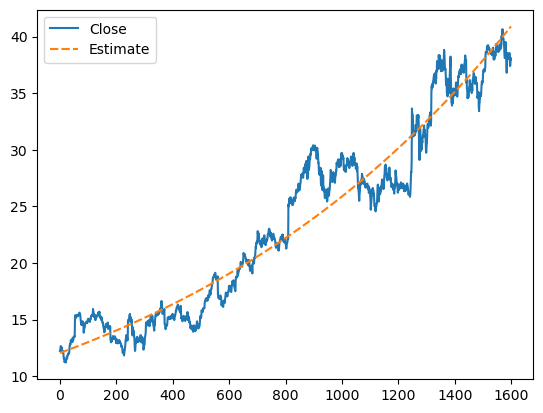

In [51]:
seaborn.lineplot(removeExponent.loc[:,["Close","Estimate"]])

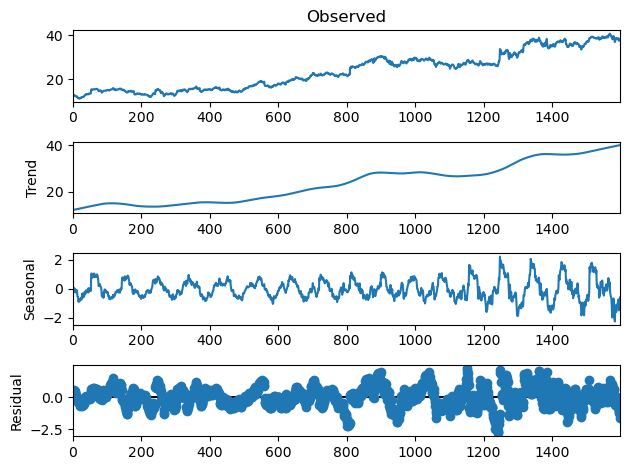

In [52]:
##something we did not full understand. Something with seasonality, however above doesnt nescessary show seasonality

from statsmodels.tsa.seasonal import STL

closeFrame = removeExponent.loc[:,"Close"]
closeFrame.index = [i for i in range(closeFrame.shape[0])]

res = STL(np.array(closeFrame), period=90).fit()
fig = res.plot()

In [53]:
#needed for ARMA model
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller


plot_pacf(dfTrySomething['NoExp'].dropna());
plot_acf(dfTrySomething['NoExp'].dropna());

ad_fuller_result = adfuller(dfTrySomething['NoExp'].dropna())
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

NameError: name 'dfTrySomething' is not defined

In [54]:
def preprocess_exp(data):
   ##first let us fit log(Y) = t + c, with Y value of the stock and t the time and c some constant
    PF = np.polyfit(data.loc[:,"timeT"], np.log(data.loc[:,"Close"]), 1)

    #use the estimates to calculate the curve
    removeExponent = data.loc[:,["Close", "timeT"]]
    removeExponent["Estimate"] = np.exp(PF[0]*removeExponent["timeT"]+PF[1])
    removeExponent["NoExp"] = removeExponent["Close"]/removeExponent["Estimate"] ##devide by trend
    
    return removeExponent[['timeT','NoExp']], PF

def reprocess_exp(data, PF):
    #use the estimates to calculate the curve
    addExponent = data.loc[:,["NoExp", "timeT"]]
    addExponent["Estimate"] = np.exp(PF[0]*removeExponent["timeT"]+PF[1])
    removeExponent["EstimateClose"] = removeExponent["NoExp"]*removeExponent["Estimate"] ##devide by trend
    
    return removeExponent[['timeT', 'EstimateClose']]



In [55]:
## Do not use ##

from statsmodels.tsa.seasonal import STL

def preprocess_stl(data):
    #something we did not fully understand. Something with seasonality, however above doesn't necessarily show seasonality
    closeFrame = removeExponent.loc[:, "Close"]
    closeFrame.index = [i for i in range(closeFrame.shape[0])]

    res = STL(np.array(closeFrame), period=90).fit()
    residuals = res.resid
    seasonal_component = res.seasonal
    trend_component = res.trend
    return residuals, seasonal_component, trend_component

def reprocess_stl(data, seasonal_component, trend_component, residual_component):
    # Reverse the seasonal adjustment
    reprocessed_series = data + seasonal_component
    # Reverse the trend adjustment
    reprocessed_series += trend_component
    # Reverse the residual adjustment
    reprocessed_series += residual_component

    return reprocessed_series


<Axes: >

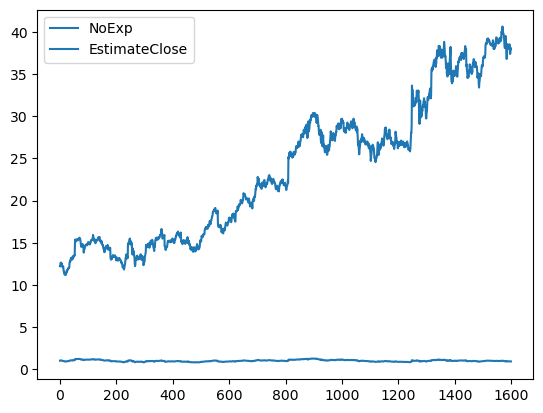

In [59]:
data_train_prep, PF = preprocess_exp(data_train)

seaborn.lineplot(data_train_prep[['NoExp']])

data_train_est = reprocess_exp(data_train_prep, PF)

seaborn.lineplot(data_train_est[['EstimateClose']])

In [ ]:
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
import numpy as np

def series_to_supervised(data, n_in=1, n_out=1, dropnan = True):
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

data_clean = data[['Close', 'Open', 'High', 'Low', 'Volume']]
reframed = series_to_supervised(data_clean.values)
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)

print(reframed)

# set desired prediction window
n = 5

# Calculate the split index for 80/20 split, considering multiples of 5
split_index = int(len(reframed) * 0.8) // n * n
end_index = reframed.shape[0] // n * n

# split into train and test sets
values = reframed.values
train = values[:split_index, :]
test = values[split_index:end_index:, :]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

print(X_train, y_train, X_test, y_test)


      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)    var5(t-1)    var1(t)
1     12.214467  12.179100  12.285949  12.128041   74626675.0  12.200021
2     12.200021  12.216709  12.265526  12.123558   72362219.0  12.610732
3     12.610732  12.258552  12.627668  12.230407  153071607.0  12.655066
4     12.655066  12.600022  12.667519  12.541990   97178890.0  12.458801
5     12.458801  12.587818  12.596286  12.354941  133277692.0  12.586572
...         ...        ...        ...        ...          ...        ...
2012  61.924999  63.549999  63.694500  61.549999   42612000.0  60.987000
2013  60.987000  61.400501  61.745800  60.573502   36998000.0  60.862999
2014  60.862999  61.000500  61.379398  60.279999   32894000.0  61.000500
2015  61.000500  61.400002  61.673500  60.510502   31344000.0  61.307499
2016  61.307499  60.294998  61.493999  60.239498   30626000.0  61.185501

[2016 rows x 6 columns]
(1610, 1, 5) (1610,) (405, 1, 5) (405,)
[[[1.22144670e+01 1.21791000e+01 1.22859488e+01 1.21280413e

In [ ]:
import matplotlib.pyplot as plt

# define parameters
verbose, epochs, batch_size = 2, 50, 72
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(n_timesteps, n_features)))  # Add LSTM layer with 50 units
model.add(RepeatVector(n_outputs))  # Repeat the output sequence
model.add(Dense(1))  # Add a dense layer with 1 unit
model.compile(loss='mae', optimizer='adam')  # Compile the model with mean absolute error loss and Adam optimizer
# fit network
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=verbose)  # Train the model



Epoch 1/50
23/23 - 2s - loss: 23.4140 - val_loss: 48.8897 - 2s/epoch - 68ms/step
Epoch 2/50
23/23 - 0s - loss: 23.2509 - val_loss: 48.7266 - 50ms/epoch - 2ms/step
Epoch 3/50
23/23 - 0s - loss: 23.0877 - val_loss: 48.5634 - 52ms/epoch - 2ms/step
Epoch 4/50
23/23 - 0s - loss: 22.9246 - val_loss: 48.4003 - 62ms/epoch - 3ms/step
Epoch 5/50
23/23 - 0s - loss: 22.7614 - val_loss: 48.2372 - 58ms/epoch - 3ms/step
Epoch 6/50
23/23 - 0s - loss: 22.5983 - val_loss: 48.0740 - 53ms/epoch - 2ms/step
Epoch 7/50
23/23 - 0s - loss: 22.4352 - val_loss: 47.9109 - 54ms/epoch - 2ms/step
Epoch 8/50
23/23 - 0s - loss: 22.2721 - val_loss: 47.7478 - 53ms/epoch - 2ms/step
Epoch 9/50
23/23 - 0s - loss: 22.1089 - val_loss: 47.5846 - 55ms/epoch - 2ms/step
Epoch 10/50
23/23 - 0s - loss: 21.9458 - val_loss: 47.4215 - 58ms/epoch - 3ms/step
Epoch 11/50
23/23 - 0s - loss: 21.7827 - val_loss: 47.2584 - 65ms/epoch - 3ms/step
Epoch 12/50
23/23 - 0s - loss: 21.6195 - val_loss: 47.0952 - 57ms/epoch - 2ms/step
Epoch 13/50
23

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(X_test)
print(yhat.shape)


13/13 [==============================] - 0s 1ms/step
(405, 1, 1)


In [ ]:
###

removeExponent




1600
